# __Presents all data from the Frequency Response Magnetophosphene study__
## effect of ELF-MF (up to 300Hz) on magnetophosphene perception threshold

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import re

/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['font.family']='mono'
plt.rcParams['font.size']=15

sns.set_style("whitegrid")

In [8]:
%matplotlib inline

## considering only subject # 13 to # 60
* 1 to 12 do not have 5Hz to 15Hz

In [10]:
folder_res = '../DATA/ResTables/'
list_files = [x for x in listdir(folder_res) if x.endswith('.csv')]

All_thr = pd.DataFrame()
Bad_ID = [13, 28, 39, 41, 50, 52, 54, 60]
# Bad_ID = []

for file_name in list_files:
    _id = int(''.join(re.findall('[0-9]',file_name)))
    if _id in Bad_ID:
        continue
    data = pd.read_csv(folder_res+file_name)
    All_thr = All_thr.append(data)

# dB/dt threshold
All_thr['dBdt'] = All_thr['n_Threshold'] * All_thr['Frequency']

## Extract percentage of perception for each frequency

In [11]:
frequencies = All_thr.Frequency.unique()
frequencies.sort()

In [12]:
distr_perceived = pd.Series(index = frequencies, dtype=float)

for fr in frequencies:
    df = All_thr.query(f'Frequency=={fr}')['Perceived']
    percentage = df.sum()/len(df)

    
    distr_perceived[fr] = percentage

### Perception rate over frequency

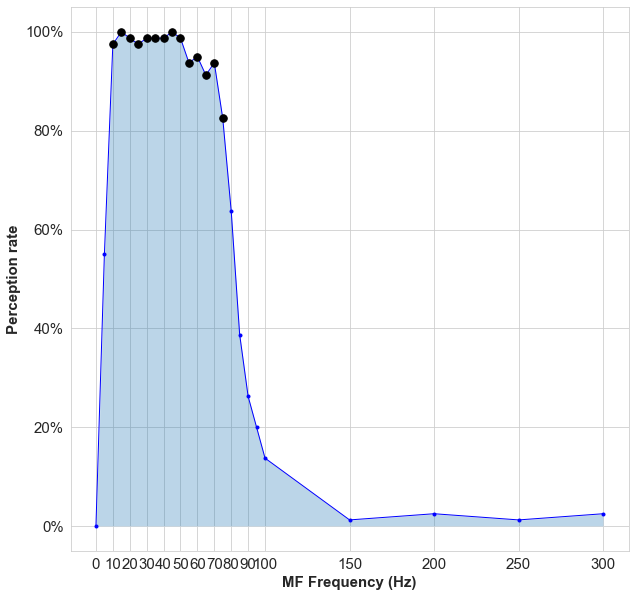

In [17]:
fig, ax  = plt.subplots()
pl1 = ax.plot(distr_perceived.index, distr_perceived, color='blue', lw='1', marker='.')
ax.fill_between(distr_perceived.index, 0, distr_perceived, alpha=.3)

ax.plot(distr_perceived[distr_perceived > 0.8], 'k.', ms=15)
# ax.plot(distr_perceived[distr_perceived > 0.95], 'r.')

subfreq=[0,10,20,30,40,50,60,70,80,90,100,150,200,250,300]
plt.xticks(subfreq)
plt.xlabel('MF Frequency (Hz)', {'fontweight':'bold'})
plt.ylabel('Perception rate', {'fontweight':'bold'})

import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # change [0-1] into [0-100%]

## raw representation of threshold

Text(0.5, 0, 'Frequency (Hz)')

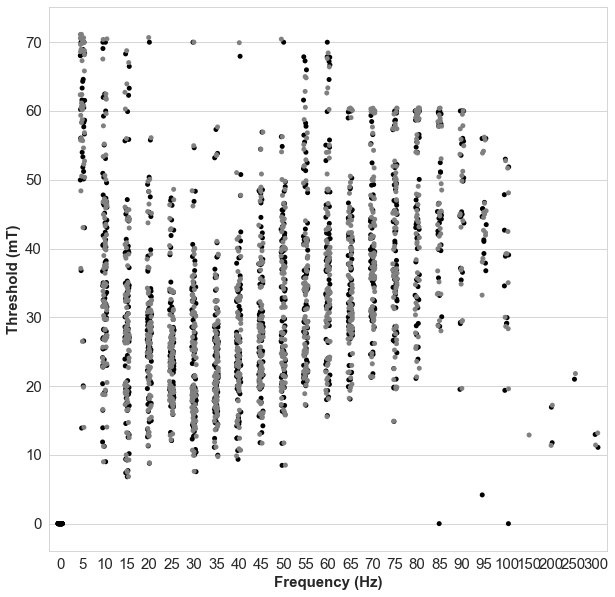

In [136]:
plt.figure()
sns.stripplot(x="Frequency", y="Threshold", data=All_thr, color='black')
sns.stripplot(x="Frequency", y="n_Threshold", data=All_thr, color='grey')
plt.ylabel('Threshold (mT)', {'fontweight':'bold'})
plt.xlabel('Frequency (Hz)', {'fontweight':'bold'})

---
# __Regression models__
> to express threshold value as a function of frequency

We chose only the frequncies for which we have over 80% perception

### __Using StatsModels for statistics__
https://ostwalprasad.github.io/machine-learning/Polynomial-Regression-using-statsmodel.html

### __Using sklearn linear_model - polynomialFeatures__
(can be done with numpy poly1d)

### __Using scipy for curve optimization with exponential model__

In [23]:
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

from scipy.optimize import curve_fit


1. preparing the data for modeling with mT as response

In [97]:
idxFreq = distr_perceived[distr_perceived >0.8].index.values.tolist()

data = All_thr.query(f'Frequency in {idxFreq}')[['Frequency','n_Threshold','dBdt']]

#  remove nan
data.dropna(subset=['n_Threshold'], inplace=True)

Freq = data.Frequency[:, np.newaxis]

FLUX = False

if FLUX:
    response1 = 'n_Threshold'
    response2 = 'dBdt'
else:
    response1 = 'dBdt'
    response2 = 'n_Threshold'
    
Y = data[response1][:, np.newaxis]
YY = data[response2][:, np.newaxis]

# new frequency axis for prediction
fr_min = 5
fr_max = 100
nFreq = np.arange(fr_min,fr_max)[:, np.newaxis]

2. Polynomial model $y = ax^{2} + bx + c$

In [50]:
polynomial_features = PolynomialFeatures(degree=2)
x = polynomial_features.fit_transform(Freq)
new_x = polynomial_features.fit_transform(nFreq)

3. Simple model $y = ax^{2} + b$ ---> __I CHOSE THIS ONE IN THIS EXAMPLE__

In [92]:
x = sm.add_constant(Freq**2)
new_x = sm.add_constant(nFreq**2)

4. Exponential model $y = ae^{-bx} + c$

In [51]:
def func(x,a,b,c):
    return a * np.exp(-b * x) + c

coef_opt, cov = curve_fit(func, data['Frequency'], data['dBdt'])

/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


### __Results__

In [98]:
model = sm.OLS(Y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     2917.
Date:                Wed, 13 May 2020   Prob (F-statistic):          9.54e-307
Time:                        10:17:15   Log-Likelihood:                -10095.
No. Observations:                1063   AIC:                         2.019e+04
Df Residuals:                    1061   BIC:                         2.020e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2070.9492    158.480     13.068      0.000    1759.979    2381.920
x1             3.1115      0.058     54.009      0.000       2.999       3.225
==============================================================================
Omnibus:                      116.735   Durbin-Watson:                   1.187
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              256.289
Skew:                           0.646   Prob(JB):                     2.23e-56
Kurtosis:                       5.029   Cond. No.                     4.41e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### __Predictions__

__compute predictions with Confidence intervals & Prediction intervals__

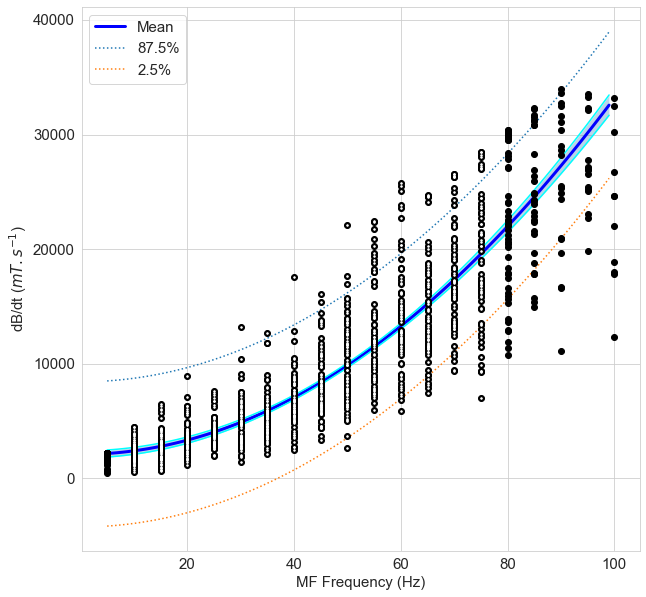

In [99]:
predictions = model.get_prediction(new_x)
conf_95 = predictions.summary_frame()

# alpha = 0.01
# conf_a = predictions.summary_frame(alpha=alpha)
# display(conf_01)

fig, ax1 = plt.subplots()
nFreq = nFreq.ravel()
plt.plot(nFreq,conf_95['mean'],'b', linewidth=3, label="Mean")
plt.plot(nFreq,conf_95['mean_ci_lower'],'cyan')
plt.plot(nFreq,conf_95['mean_ci_upper'],'cyan')
plt.fill_between(nFreq, conf_95.mean_ci_lower, conf_95.mean_ci_upper, alpha=.3)

# plt.plot(nFreq,conf_01.obs_ci_upper,':',label=f"{(1-alpha)*100}%")
plt.plot(nFreq,conf_95.obs_ci_upper,':',label="87.5%")
plt.plot(nFreq,conf_95.obs_ci_lower,':',label="2.5%")
# plt.plot(nFreq,conf_01.obs_ci_lower,'--',label=f"{alpha*100}%",linewidth=2)

subdata = All_thr.query('@fr_min <= Frequency <= @fr_max')
plt.plot(subdata.Frequency, subdata[response1], 'ko')
plt.plot(Freq, Y, 'w.', ms=3)

plt.xlabel('MF Frequency (Hz)')
if FLUX:
    plt.ylabel('Threshold (mT)')
else:
    plt.ylabel(r'dB/dt ($mT.s^{-1}$)')

plt.legend()

# plot perception rate
if False:
    ax2 = ax1.twinx()
    ax2.plot(distr_perceived.index, distr_perceived, color='blue', lw='0.5')
    ax2.fill_between(distr_perceived.index, 0, distr_perceived, alpha=.1)

### __Showing same data and model for orther response__

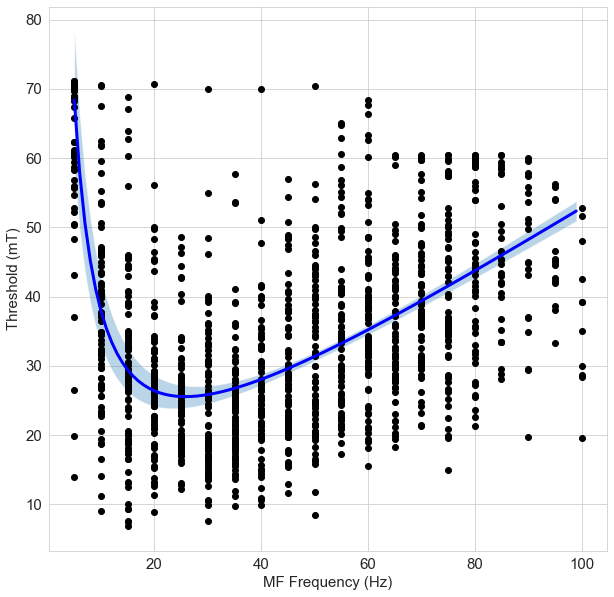

In [134]:
plt.plot(subdata.Frequency, subdata[response2], 'ko')
plt.plot(nFreq, conf_95['mean']/(nFreq*2*np.pi), 'b',linewidth=3, label="Mean")
plt.fill_between(nFreq, conf_95['mean_ci_lower']/(nFreq*2*np.pi), conf_95['mean_ci_upper']/(nFreq*2*np.pi), alpha=.3)

plt.xlabel('MF Frequency (Hz)')
if ~FLUX:
    plt.ylabel('Threshold (mT)')
else:
    plt.ylabel(r'dB/dt ($mT.s^{-1}$)')

In [101]:
nFreq[(conf_95['mean']/nFreq).argmin()]

26

$B = \frac{1}{2\pi f} (a f^{2} + b)$

$dB/df = \frac{af^{2}-b}{2\pi f^{2}}$

$f = \sqrt{- \frac{b}{a}}$ --> complex number

In [133]:
import math
a = np.float64(3.1115)
b = np.float64(2070.9492)
fmin = math.sqrt(b/a)
Bmin = (a*fmin**2+b)/(2*np.pi*fmin)

print(f'The most sensitive frequency is {fmin:.3f} Hz with a mean of {Bmin:.3f} mT')

The most sensitive frequency is 25.799 Hz with a mean of 25.552 mT
